In [2]:
import os
import torch
import torch.nn as nn
import torch.distributions as td
import numpy as np 
import matplotlib.pyplot as plt
from tqdm.notebook import trange 

from flow.nvp_y import RealNVP

def convert(x):
    return torch.as_tensor(x).float()

Data: D.shape=(50000, 64, 64) Y.shape=(50000, 2)


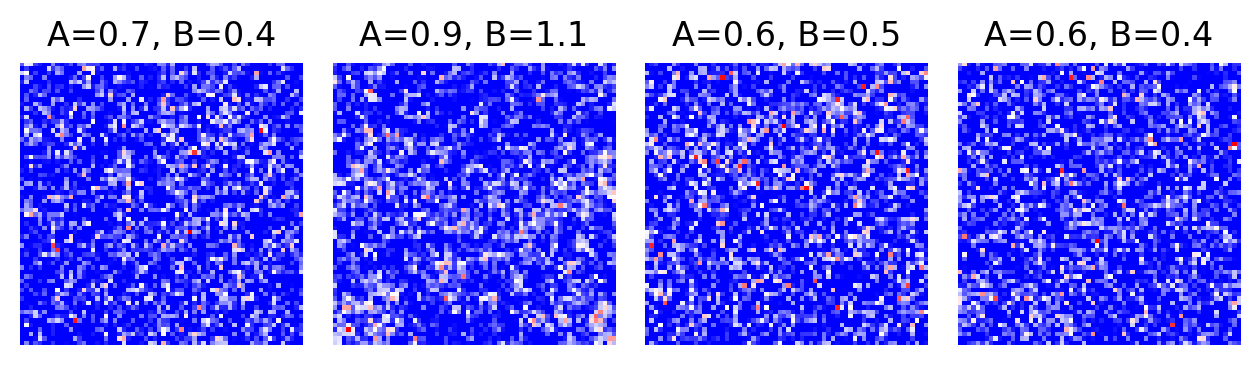

Summaries: X.shape=(50000, 2) Y.shape=(50000, 2)


In [3]:
field_type = "gaussian" 
data_dir = "data/"

AB = np.array([1., 1.])
lower = np.array([0.1, .1])
upper = np.array([2., 2.])
parameter_names = ["A", "B"]

# Load data 
D = np.load(os.path.join(data_dir, field_type + "_fields.npy"))
Y = np.load(os.path.join(data_dir, field_type + "_fields_parameters.npy"))
D0 = np.load(os.path.join(data_dir, field_type + "_fields_fiducial.npy")) # At true cosmology

covariance = np.load(os.path.join(data_dir, field_type + "_fields_covariance.npy"))

print(f"Data: {D.shape=} {Y.shape=}")

fig, axs = plt.subplots(1, 4, dpi=200)
for i, ax in enumerate(axs):
    A, B = Y[i]
    ax.set_title(f"{A=:.1f}, {B=:.1f}")
    im = ax.imshow(D[i], cmap="bwr")
    ax.axis("off")
plt.tight_layout()
plt.show()

# Load compressed data
X = np.load(os.path.join(data_dir, field_type + "_nn_summaries.npy"))
X_ = np.load(os.path.join(data_dir, field_type + "_nn_summary_data.npy"))

def preprocess_fn(x, y):
    return (x - Y.mean(axis=0)), (y - X.mean(axis=0))

print(f"Summaries: {X.shape=} {Y.shape=}")

In [4]:
# Data
data_dim = X.shape[-1] 
parameter_dim = Y.shape[-1]
# Model
H = 32 # Hidden size
L = 2 # Layers
# Optimisation
lr = 1e-4
n_steps = 10_000
batch_size = 400

In [5]:
activation = nn.Tanh # ReLU

net_s = lambda: nn.Sequential(
    nn.Linear(data_dim + parameter_dim, H), 
    activation(),
    nn.Linear(H, H), 
    activation(),
    nn.Linear(H, data_dim), 
    # activation()
)
net_t = lambda: nn.Sequential(
    nn.Linear(data_dim + parameter_dim, H), 
    activation(), 
    nn.Linear(H, H), 
    activation(), 
    nn.Linear(H, data_dim)
)

masks = torch.stack([torch.arange(0, data_dim).float() % 2] * L)

prior = td.MultivariateNormal(torch.zeros(data_dim), torch.eye(data_dim))

flow = RealNVP(net_s, net_t, masks, prior) #preprocess_fn)

In [6]:
def get_data(n):
    ix = np.random.randint(len(X), size=(n,))
    return convert(X[ix]), convert(Y[ix])

optimizer = torch.optim.Adam(flow.parameters(), lr=lr, weight_decay=1e-5)

losses = []
with trange(n_steps) as steps:
    for s in steps:
        x, y = get_data(batch_size)

        loss = -flow.log_prob(y, x).mean()
        
        optimizer.zero_grad()
        loss.backward(retain_graph=True)
        optimizer.step()

        losses.append(loss.item())
        steps.set_postfix(loss=f"{loss:.3E}")

  0%|          | 0/10000 [00:00<?, ?it/s]

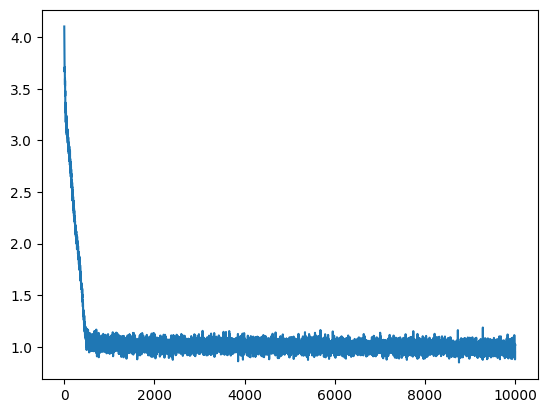

In [7]:
plt.figure()
plt.plot(losses)
plt.show()

(50000, 2) (50000, 2)
(50000, 2)


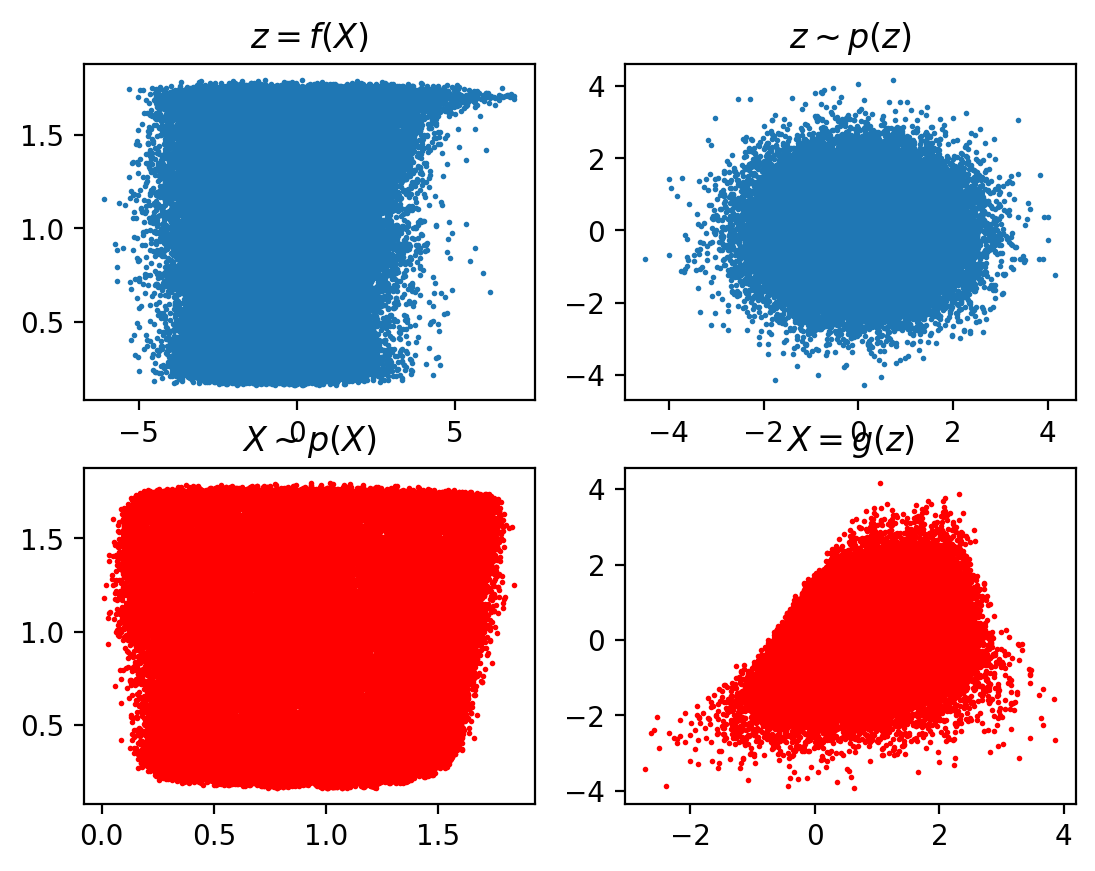

In [8]:
plt.figure(dpi=200)
print(X.shape, Y.shape)
z = flow.forward(convert(X), convert(Y))[0].detach().numpy()
plt.subplot(221)
plt.scatter(z[:, 0], z[:, 1], s=1.)
plt.title(r'$z = f(X)$')

z = prior.sample((len(X),))
plt.subplot(222)
plt.scatter(z[:, 0], z[:, 1], s=1.)
plt.title(r'$z \sim p(z)$')

plt.subplot(223)
plt.scatter(X[:, 0], X[:, 1], c='r', s=1.)
plt.title(r'$X \sim p(X)$')

plt.subplot(224)
x = flow.sample(len(X), convert(Y)).detach().numpy() # Sample plot at parameters given
print(x.shape)
plt.scatter(x[:, 0], x[:, 1], c='r', s=1.)
plt.title(r'$X = g(z)$')

plt.show()

In [9]:
(400_000 - 4096 - 2) / (400_000 - 1)

0.989757474393686

In [10]:
# alpha = np.array([0.5, 0.5])
# # alpha = np.load(os.path.join(data_dir, "alpha.npy"))
# derivatives = np.load(os.path.join(data_dir, field_type + "_derivatives.npy"))
# mean = np.load(os.path.join(data_dir, field_type + "_mean.npy"))
# covariance = np.load(os.path.join(data_dir, field_type + "_covariance.npy"))
# precision = np.linalg.inv(covariance) # Assuming H ~ 1

# # Is this right? Forecast assuming linear model and Gaussian errors
# Finv = np.linalg.inv(np.linalg.multi_dot([derivatives, precision, derivatives.T]))

In [11]:
n_posterior_samples = 40_000

In [12]:
# Finv = np.load(os.path.join(data_dir, field_type + "_Finv.npy"))

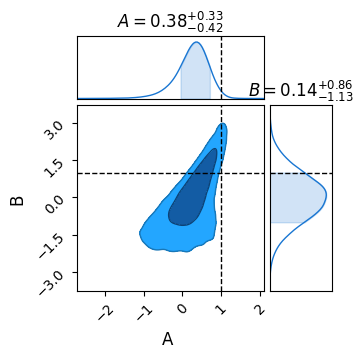

In [13]:
from chainconsumer import ChainConsumer 

posterior_samples = flow.sample(
    n_posterior_samples, 
    torch.tile(convert(X_), (n_posterior_samples, 1))
)
posterior_samples = posterior_samples.detach().numpy()

c = ChainConsumer()
c.add_chain(posterior_samples, parameters=parameter_names)
# c.add_covariance(AB, Finv, parameters=parameter_names)
fig = c.plotter.plot(truth=AB)

In [14]:
from powerbox import get_power 
from chainconsumer import ChainConsumer 

def get_F(AB, field):
    """
        Calculate the Fisher information of the field
        given the parameter values A, B = AB.
    """
    A, B = AB
    
    # Power spectrum and k-modes
    Pk, k = get_power(
        field, boxlength=1., ignore_zero_mode=True
    )
    
    # Inverse covariance (covariance is diagonal)
    Cinv = np.diag(1. / Pk) 

    # Covariance derivatives
    C_A = np.diag(k ** -B)
    C_B = np.diag(-Pk * np.log(k))

    # Fisher matrix elements for each parameter
    F_AA = 0.5 * np.trace((C_A @ Cinv @ C_A @ Cinv))
    F_AB = 0.5 * np.trace((C_A @ Cinv @ C_B @ Cinv))
    F_BA = 0.5 * np.trace((C_B @ Cinv @ C_A @ Cinv))
    F_BB = 0.5 * np.trace((C_B @ Cinv @ C_B @ Cinv))

    return np.array([[F_AA, F_AB], [F_BA, F_BB]])

F = get_F(alpha, D0.mean(axis=0))
Finv = np.linalg.inv(F)

posterior_samples = flow.sample(
    n_posterior_samples, 
    torch.tile(convert(X_), (n_posterior_samples, 1))
)
posterior_samples = posterior_samples.detach().numpy()

c = ChainConsumer()
c.add_chain(posterior_samples, parameters=parameter_names)
c.add_covariance(alpha, Finv, parameters=parameter_names)
fig = c.plotter.plot(truth=alpha)

NameError: name 'alpha' is not defined

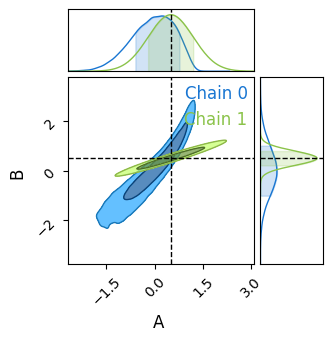

In [ ]:
def fisher(θ, k, N):
    A, B = θ
    _Pk = A * k ** -B 
    
    Cinv = np.diag(1. / _Pk)
    C_A = np.diag(k ** -B)
    C_B = np.diag(-_Pk * np.log(k))

    F_AA = 0.5 * np.trace((C_A @ Cinv @ C_A @ Cinv))
    F_AB = 0.5 * np.trace((C_A @ Cinv @ C_B @ Cinv))
    F_BA = 0.5 * np.trace((C_B @ Cinv @ C_A @ Cinv))
    F_BB = 0.5 * np.trace((C_B @ Cinv @ C_B @ Cinv))

    F = np.array(
        [
            [F_AA, F_AB], 
            [F_BA, F_BB]
        ]
    )
    return F

bins_field = np.array([
    6.74175608,  15.45734344,  24.48480767,  34.53463474,
    43.70699212,  53.82159711,  63.83737213,  73.50921216,
    83.52835261,  93.09965685, 103.15862259, 112.95713549,
    122.92965035, 132.46581717, 142.10107612, 151.73095604,
    161.58263501, 171.75896138, 181.28953473, 191.21116407,
    200.95365826, 210.71623074, 220.44628398, 230.19829726,
    239.89968893, 250.02951477, 259.70986696, 268.66110077,
    276.99921658
])

alpha = np.array([0.5, 0.5])
F = fisher(alpha, bins_field, D.shape[-1])
Finv = np.linalg.inv(F)

from chainconsumer import ChainConsumer

c = ChainConsumer()
c.add_chain(posterior_samples, parameters=parameter_names)
c.add_covariance(alpha, Finv)
c.plotter.plot(truth=alpha)
plt.show()

In [ ]:
from mflow.made import MADE
from mflow.batch import BatchNormFlow
from fmlwperm import Perm
from flow import Flow

data_dim = 2
H = 32
context_dim = 2

flow = Flow(
    MADE(data_dim, H, context_dim, act="tanh"),
    BatchNormFlow(data_dim),
    Perm(data_dim),
    MADE(data_dim, H, context_dim, act="tanh"),
    BatchNormFlow(data_dim),
    Perm(data_dim),
    MADE(data_dim, H, context_dim, act="tanh"),
)



ModuleNotFoundError: No module named 'mflow'